In [1]:
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import mra

In [2]:
plt.rcParams['text.usetex'] = True
np.random.seed(123)

# Create parameters

In [3]:
rho = 1.
num_points = [10, 50]
eps_sublevel = percent = 0.1

alpha = 1 # proximal term coefficient

num_resources = 50
num_agents = num_participants = 100

filename = "local_resal_N%s_%.2f_n%d_m%d"%(",".join(list(map(str, num_points))), eps_sublevel, num_agents, num_resources)

In [4]:

num_resource_per_participant = 10
inner_size = 5

A_all, A_ineq, b_ineq = mra.resal_data(num_resources, num_participants, inner_size)

In [5]:
b_norm = np.linalg.norm(b_ineq)

# CVXPY centralized solution

In [6]:
true_x, true_f, true_lamb = mra.centralized_solution_resal(A_all, A_ineq, b_ineq)
print(f"{true_f=}")

true_f=-91.86415947258942


In [7]:
(true_lamb.max() - true_lamb.min()) / true_lamb.max()

1.0000000208130848

In [8]:
true_lamb.shape, true_x.shape

((50, 1), (5000, 1))

In [9]:
fun_agents_eps = []
fun_agents_noisy_y = []

for i in range(num_agents):
    fun_agents_eps += [lambda lamb_k, K, i=i: mra.resal_query_multiple_actions(lamb_k, i, A_all,  
                                                                           eps_sublevel=eps_sublevel, K=K, return_best=True)]
    fun_agents_noisy_y += [lambda lamb_k, K, i=i: mra.resal_query_multiple_actions_noisy_prices(lamb_k, i, A_all,
                                                                        percent=percent, K=K)]

fun_obj_val = lambda x_k: mra.resal_obj_value(x_k, A_all)

# Localization

In [10]:
price_max = 3 * true_lamb.max()
price_min = (1./3) * true_lamb.min()
K_i = num_points
N = num_agents
primal_var_size = A_ineq.shape[1]

In [11]:
all_results_eps = {}
all_results_noisy_y = {}
for K_i in num_points:
    print(f"{K_i=}")
    all_results_eps[K_i]  = mra.price_localization_primal_recovery(fun_agents_eps, fun_obj_val, primal_var_size, A_ineq=A_ineq, b_ineq=b_ineq, 
                                                            price_max=price_max, price_min=price_min, alpha=alpha, relaxed=True, 
                                                            postprocessing=1, K_i=K_i, num_iters=200, 
                                                            method="accpm_l2", true_f=true_f, print_freq=50, eps_lamb=1e-28,
                                                            res_type="primal_compl_slack", history=1)[0]


    all_results_noisy_y[K_i]  = mra.price_localization_primal_recovery(fun_agents_noisy_y, fun_obj_val, primal_var_size, 
                                                                                                      A_ineq=A_ineq, b_ineq=b_ineq, 
                                                            price_max=price_max, price_min=price_min, alpha=alpha, relaxed=True, 
                                                            postprocessing=1, K_i=K_i, num_iters=200, 
                                                            method="accpm_l2", true_f=true_f, print_freq=50, eps_lamb=1e-28,
                                                            res_type="primal_compl_slack", history=1)[0]

K_i=10


/Users/parshakova.tanya/Documents/projects/mra_precovery/mra/localization_prim_rec.py:85: RuntimeWarning: divide by zero encountered in scalar divide
  lamb_rel_diff = np.linalg.norm(lamb_k - lamb_prev) / np.linalg.norm(lamb_prev)


epoch=0, f_subopt_xk=7.7579E-02,  f_subopt_mra=7.3687E-03,  viol_xk=4.2108E+02, viol_mra=2.9336E+02, lamb_rel_diff=INF
epoch=50, f_subopt_xk=2.2952E-02,  f_subopt_mra=5.9896E-03,  viol_xk=9.1192E+01, viol_mra=8.8193E+00, lamb_rel_diff=1.3380E-01
epoch=100, f_subopt_xk=1.6534E-02,  f_subopt_mra=3.8377E-03,  viol_xk=7.1506E+01, viol_mra=1.2357E+00, lamb_rel_diff=6.4265E-02
epoch=150, f_subopt_xk=1.9755E-02,  f_subopt_mra=2.4970E-03,  viol_xk=2.7558E+01, viol_mra=1.8082E-01, lamb_rel_diff=1.8129E-02
epoch=199, f_subopt_xk=2.8174E-03,  f_subopt_mra=2.3881E-03,  viol_xk=1.1105E+01, viol_mra=2.7043E-02, lamb_rel_diff=7.1027E-03
epoch=0, f_subopt_xk=7.7579E-02,  f_subopt_mra=7.1786E-02,  viol_xk=4.2108E+02, viol_mra=4.0431E+02, lamb_rel_diff=INF
epoch=50, f_subopt_xk=2.2952E-02,  f_subopt_mra=2.5989E-02,  viol_xk=9.1192E+01, viol_mra=3.9862E+01, lamb_rel_diff=1.3380E-01
epoch=100, f_subopt_xk=1.6534E-02,  f_subopt_mra=5.7706E-03,  viol_xk=7.1506E+01, viol_mra=1.0190E+01, lamb_rel_diff=6.4265E

In [12]:
K_i = min(num_points)
if len(all_results_noisy_y[K_i]["subopt_xk"]) > len(all_results_eps[K_i]["subopt_xk"]):
    all_res = all_results_noisy_y[K_i]
else:
    all_res = all_results_eps[K_i]

In [18]:
for i, K_i in enumerate(num_points):
      print(np.array(all_res["viol_primal_xk"])[-1] / np.linalg.norm(b_norm),
      "sub_eps", np.array(all_results_eps[K_i]["viol_primal_mra_xk"])[-1] / np.linalg.norm(b_norm),
      "noisy_y", np.array(all_results_noisy_y[K_i]["viol_primal_mra_xk"])[-1] / np.linalg.norm(b_norm))

0.04287888503328487 sub_eps 1.6463394971728301e-13 noisy_y 5.158603172487873e-12
0.04287888503328487 sub_eps 5.632169353861463e-12 noisy_y 1.8906169322708155e-12


In [7]:
import pickle

# with open(f"../results/{filename}_dict.pkl", "wb") as file:
#     pickle.dump({"eps":all_results_eps, "noisy_y":all_results_noisy_y}, file)
with open(f"../results/{filename}_dict.pkl", "rb") as file:
    res = pickle.load(file)
    all_results_eps = res["eps"]
    all_results_noisy_y = res["noisy_y"]
    K_i = min(num_points)
    if len(all_results_noisy_y[K_i]["subopt_xk"]) > len(all_results_eps[K_i]["subopt_xk"]):
        all_res = all_results_noisy_y[K_i]
    else:
        all_res = all_results_eps[K_i]
res["eps"].keys()

dict_keys([10, 50])

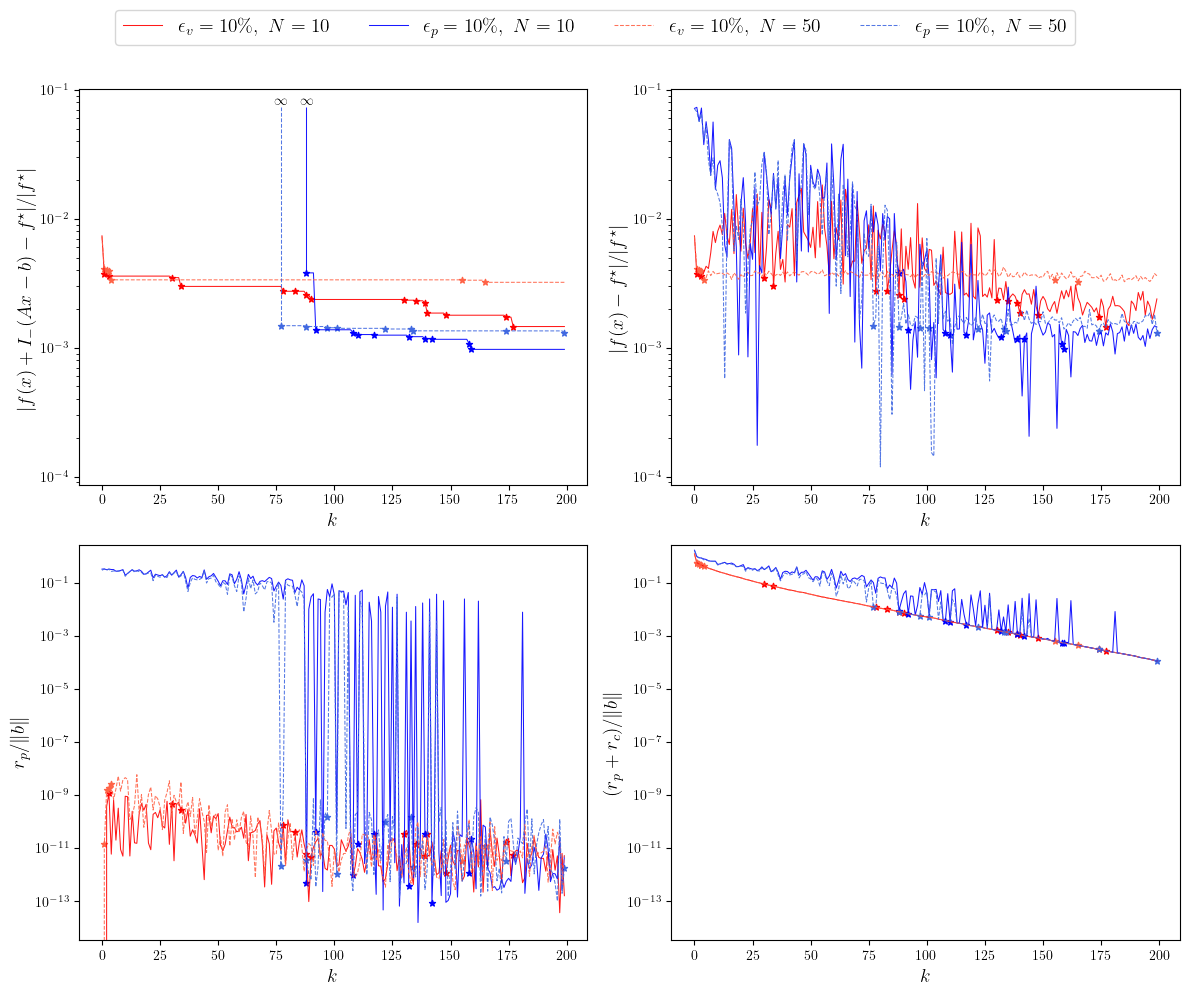

In [8]:
mra.plot_N_all_metrics_4x(all_results_eps, all_results_noisy_y, eps_sublevel, true_f, 
                                b_norm, num_points, filename)

In [10]:
for K_i in num_points:
    print(f"{K_i=}")
    eps_subopt = (np.abs(np.array(all_results_eps[K_i]["f_mra_xk"]) - true_f)) / np.abs(true_f)
    eps_res = np.array(all_results_eps[K_i]["viol_primal_mra_xk"]) / b_norm
    noisy_y_subopt = (np.abs(np.array(all_results_noisy_y[K_i]["f_mra_xk"]) - true_f)) / np.abs(true_f)
    noisy_y_res = np.array(all_results_noisy_y[K_i]["viol_primal_mra_xk"]) / b_norm

    res_tol = 1e-6
    first_eps   = next((i for i,x in enumerate(eps_res)   if x < res_tol), None)
    first_noisy = next((i for i,x in enumerate(noisy_y_res) if x < res_tol), None)
    print(f"eps → {first_eps}, noisy → {first_noisy}")

    eps_subopt = np.array(mra.subopt_of_best_feas_point_only(all_results_eps[K_i], true_f, b_norm),)
    noisy_y_subopt = np.array(mra.subopt_of_best_feas_point_only(all_results_noisy_y[K_i], true_f, b_norm),)

    print(f"eps {eps_subopt[-1]*100}\%  noisy_y {noisy_y_subopt[-1]*100}\%")

K_i=10
eps → 0, noisy → 88
eps 0.1458693594821041\%  noisy_y 0.0969755829734403\%
K_i=50
eps → 0, noisy → 77
eps 0.32136441745651567\%  noisy_y 0.1304138690507857\%
